In [ ]:
import pandas as pd
import utils

isaac_df = pd.read_csv("IsaacNetflixHistory.csv")
isaac_df = utils.clean_enriched_netflix_data(isaac_df)
isaac_df.head()



c:\Users\rohan\222Proj\utils.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


,Title,Date,Type,Series Name,Season and Episode,Watch Year
0,Breaking Bad: Season 1: Pilot,2025-04-18,Show,Breaking Bad,"Season 1, Episode: Pilot",2025
1,Meet the Parents,2025-04-17,Movie,N/A,N/A,2025
2,Meet the Fockers,2025-04-16,Movie,N/A,N/A,2025
3,Suits: Season 1: Play the Man,2025-04-09,Show,Suits,"Season 1, Episode: Play the Man",2025
4,Suits: Season 1: Tricks of the Trade,2025-04-09,Show,Suits,"Season 1, Episode: Tricks of the Trade",2025


In [ ]:
import pandas as pd
import utils

rohan_df = pd.read_csv("RohanNetflixHistory.csv")
rohan_df = utils.clean_enriched_netflix_data(rohan_df)
rohan_df.head()


,Title,Date,Type,Series Name,Season and Episode,Watch Year
0,"High-Rise Invasion: I'm Sorry, Mayuko Nise",2025-02-11,Show,High-Rise Invasion,"I'm Sorry, Mayuko Nise",2025
1,High-Rise Invasion: I've Found a New Goal,2025-02-11,Show,High-Rise Invasion,I've Found a New Goal,2025
2,Suits: Season 1: Identity Crisis,2025-02-11,Show,Suits,Season 1: Identity Crisis,2025
3,Suits: Season 1: Play the Man,2025-02-11,Show,Suits,Season 1: Play the Man,2025
4,The Night Agent: Season 2: Disconnected,2025-02-11,Show,The Night Agent,Season 2: Disconnected,2025


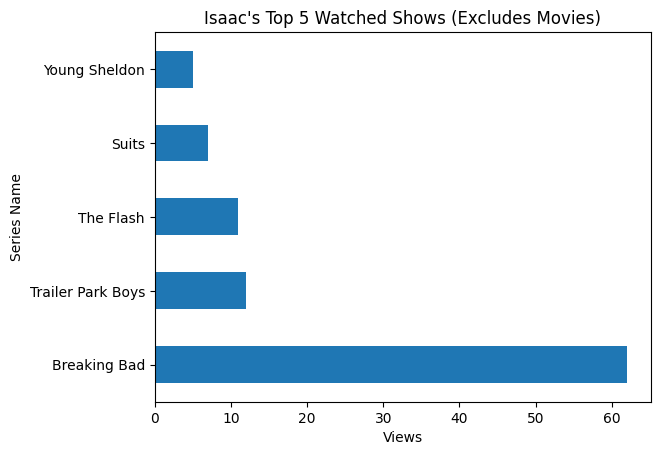

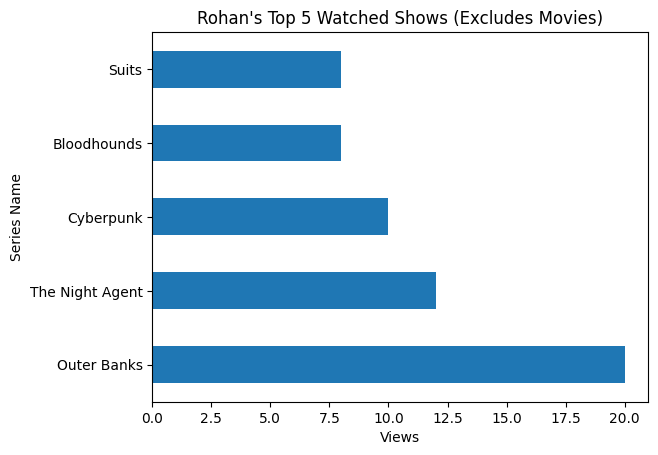

In [ ]:
import matplotlib.pyplot as plt

# Isaac's top 5 shows (exclude movies)
isaac_shows = isaac_df[isaac_df['Type'] == 'Show']
isaac_shows['Series Name'].value_counts().head(5).plot(kind='barh')
plt.title("Isaac's Top 5 Watched Shows (Excludes Movies)")
plt.xlabel('Views')
plt.ylabel('Series Name')
plt.show()

rohan_shows = rohan_df[rohan_df['Type'] == 'Show']
rohan_shows['Series Name'].value_counts().head(5).plot(kind='barh')
plt.title("Rohan's Top 5 Watched Shows (Excludes Movies)")
plt.xlabel('Views')
plt.ylabel('Series Name')
plt.show()



In [31]:
from scipy.stats import ttest_ind

isaac_binary = (isaac_df['Type'] == 'Show').astype(int)
print(isaac_binary)
rohan_binary = (rohan_df['Type'] == 'Show').astype(int)
t_stat, p_value = ttest_ind(isaac_binary, rohan_binary, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if (t_stat > 0) and (p_value / 2 < alpha):
    print("Reject H0: Isaac watches more shows (proportionally) than Rohan.")
else:
    print("Fail to reject H0: Not enough evidence that Isaac watches more shows than Rohan.")



0      1
1      0
2      0
3      1
4      1
      ..
207    1
208    1
209    0
210    0
211    0
Name: Type, Length: 212, dtype: int64
T-statistic: -3.308
P-value: 0.0010
Fail to reject H0: Not enough evidence that Isaac watches more shows than Rohan.
